In [1]:
import os
import itertools
from textwrap import wrap

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
os.chdir('../..')

In [3]:
BATCH_SIZE = 32
SQUAD_SEEDS = [28, 29, 30]
COMBINED_SEEDS = [27, 28, 29]  # SQuAD + AdversarialQA
SAVE_STEPS_SCHEDULE = [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 24, 28, 32, 36, 44, 52, 60, 68, 76, 92, 108, 124, 140, 156, 172, 188, 204, 220, 236, 252, 268, 284, 300, 316, 332, 348, 364, 380, 396, 428, 460, 492, 524, 556, 588, 620, 652, 684, 716, 748, 780, 812, 844, 876, 908, 940, 972, 1004, 1036, 1100, 1164, 1228, 1292, 1356, 1420, 1484, 1548, 1612, 1676, 1804, 1932, 2060, 2188, 2316, 2444, 2572, 2700, 2828, 2956, 3084, 3212, 3340, 3468, 3596, 3724, 3852, 3980, 4108, 4236, 4364, 4492, 4620, 4748, 4876, 5004, 5132, 5260, 5388, 5516, 5644, 5772, 5900, 6028, 6156, 6284, 6412, 6540, 6668, 6796, 6924, 7052, 7180, 7308, 7436, 7564, 7692, 7820, 7948]

In [4]:
len(SAVE_STEPS_SCHEDULE)

120

In [5]:
# (high-level category, exact test)

CHECKLIST_TESTS = [
    ('Vocabulary', 'A is COMP than B. Who is more / less COMP?'),
    ('Vocabulary', 'Intensifiers (very, super, extremely) and reducers (somewhat, kinda, etc)?'),
    ('Taxonomy', 'size, shape, age, color'),
    ('Taxonomy', 'Profession vs nationality'),
    ('Taxonomy', 'Animal vs Vehicle'),
    ('Taxonomy', 'Animal vs Vehicle v2'),
    ('Synonyms', 'Basic synonyms'),
    ('Synonyms', 'A is COMP than B. Who is antonym(COMP)? B'),
    ('Synonyms', 'A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.'),
    ('Robustness', 'Question typo'),
    ('Robustness', 'Question contractions'),
    ('Robustness', 'Add random sentence to context'),
    ('NER', 'Change name everywhere'),
    ('NER', 'Change location everywhere'),
    ('Fairness', 'M/F failure rates should be similar for different professions'),
    ('Temporal', 'There was a change in profession'),
    ('Temporal', 'Understanding before / after -> first / last.'),
    ('Negation', 'Negation in context, may or may not be in question'),
    ('Negation', 'Negation in question only.'),
    ('Coref', 'Basic coref, he / she'),
    ('Coref', 'Basic coref, his / her'),
    ('Coref', 'Former / Latter'),
    ('SRL', 'Agent / object distinction'),
    ('SRL', 'Agent / object distinction with 3 agents')
]

len(CHECKLIST_TESTS)

24

In [6]:
test_num_to_high_lvl_cat = dict(
    zip(
        range(1, 25), 
        [x[0] for x in CHECKLIST_TESTS]
    )
)

test_num_to_low_lvl_cat = dict(
    zip(
        range(1, 25), 
        [x[1] for x in CHECKLIST_TESTS]
    )
)

In [7]:
checklist_df = pd.DataFrame()

# SQuAD

for seed in SQUAD_SEEDS:
    for checkpoint in tqdm(SAVE_STEPS_SCHEDULE):
        df = pd.read_csv(
            f"predictions/checklist/albert-xlarge-v2-squadv1-wu=100-lr=3e5-bs=32-msl=384-seed={seed}/checkpoint-{checkpoint}/checklist_results_summary.txt", 
            names=['fail_rate']
        )
        assert df.shape[0] == 24
        df['checkpoint'] = checkpoint
        df['seed'] = seed
        df['test'] = df.index + 1
        df['test_type'] = df['test'].map(test_num_to_high_lvl_cat)
        df['test_name'] = df['test'].map(test_num_to_low_lvl_cat)
        df['model'] = 'SQuAD 1.1'
        
        checklist_df = checklist_df.append(df)
        
# SQuAD + AdversarialQA

for seed in COMBINED_SEEDS:
    for checkpoint in tqdm(SAVE_STEPS_SCHEDULE):
        df = pd.read_csv(
            f"predictions/checklist/albert-xlarge-v2-squadv1-adversarialall-wu=100-lr=3e5-bs=32-msl=384-seed={seed}/checkpoint-{checkpoint}/checklist_results_summary.txt", 
            names=['fail_rate']
        )
        assert df.shape[0] == 24
        df['checkpoint'] = checkpoint
        df['seed'] = seed
        df['test'] = df.index + 1
        df['test_type'] = df['test'].map(test_num_to_high_lvl_cat)
        df['test_name'] = df['test'].map(test_num_to_low_lvl_cat)
        df['model'] = 'SQuAD 1.1 + AdversarialQA'
        
        checklist_df = checklist_df.append(df)

100%|██████████| 120/120 [00:01<00:00, 95.07it/s]


In [8]:
print(checklist_df.shape)
checklist_df.head()

(17280, 7)


,fail_rate,checkpoint,seed,test,test_type,test_name,model
0,100.0%,1,28,1,Vocabulary,A is COMP than B. Who is more / less COMP?,SQuAD 1.1
1,100.0%,1,28,2,Vocabulary,"Intensifiers (very, super, extremely) and redu...",SQuAD 1.1
2,100.0%,1,28,3,Taxonomy,"size, shape, age, color",SQuAD 1.1
3,100.0%,1,28,4,Taxonomy,Profession vs nationality,SQuAD 1.1
4,100.0%,1,28,5,Taxonomy,Animal vs Vehicle,SQuAD 1.1


In [9]:
120*3*24*2

17280

In [10]:
checklist_df['model'].value_counts()

SQuAD 1.1 + AdversarialQA    8640
SQuAD 1.1                    8640
Name: model, dtype: int64

In [11]:
checklist_df['fail_rate'] = checklist_df['fail_rate'].apply(lambda x: float(x.split('%')[0]))

checklist_df['num_examples'] = checklist_df['checkpoint'] * BATCH_SIZE

In [12]:
checklist_df.head()

,fail_rate,checkpoint,seed,test,test_type,test_name,model,num_examples
0,100.0,1,28,1,Vocabulary,A is COMP than B. Who is more / less COMP?,SQuAD 1.1,32
1,100.0,1,28,2,Vocabulary,"Intensifiers (very, super, extremely) and redu...",SQuAD 1.1,32
2,100.0,1,28,3,Taxonomy,"size, shape, age, color",SQuAD 1.1,32
3,100.0,1,28,4,Taxonomy,Profession vs nationality,SQuAD 1.1,32
4,100.0,1,28,5,Taxonomy,Animal vs Vehicle,SQuAD 1.1,32


In [13]:
checklist_df.drop('test', axis=1, inplace=True)

### Test type

In [14]:
test_type_df = checklist_df.groupby(['checkpoint', 'seed', 'test_type', 'model', 'num_examples']).mean().reset_index()
print(test_type_df.shape)
test_type_df.head()

(7200, 6)


,checkpoint,seed,test_type,model,num_examples,fail_rate
0,1,27,Coref,SQuAD 1.1 + AdversarialQA,32,100.000000
1,1,27,Fairness,SQuAD 1.1 + AdversarialQA,32,100.000000
2,1,27,NER,SQuAD 1.1 + AdversarialQA,32,75.300000
3,1,27,Negation,SQuAD 1.1 + AdversarialQA,32,100.000000
4,1,27,Robustness,SQuAD 1.1 + AdversarialQA,32,52.866667


In [15]:
10*2*3*120

7200

In [16]:
test_type_df['test_type'].unique(), test_type_df['test_type'].nunique()

(array(['Coref', 'Fairness', 'NER', 'Negation', 'Robustness', 'SRL',
        'Synonyms', 'Taxonomy', 'Temporal', 'Vocabulary'], dtype=object),
 10)

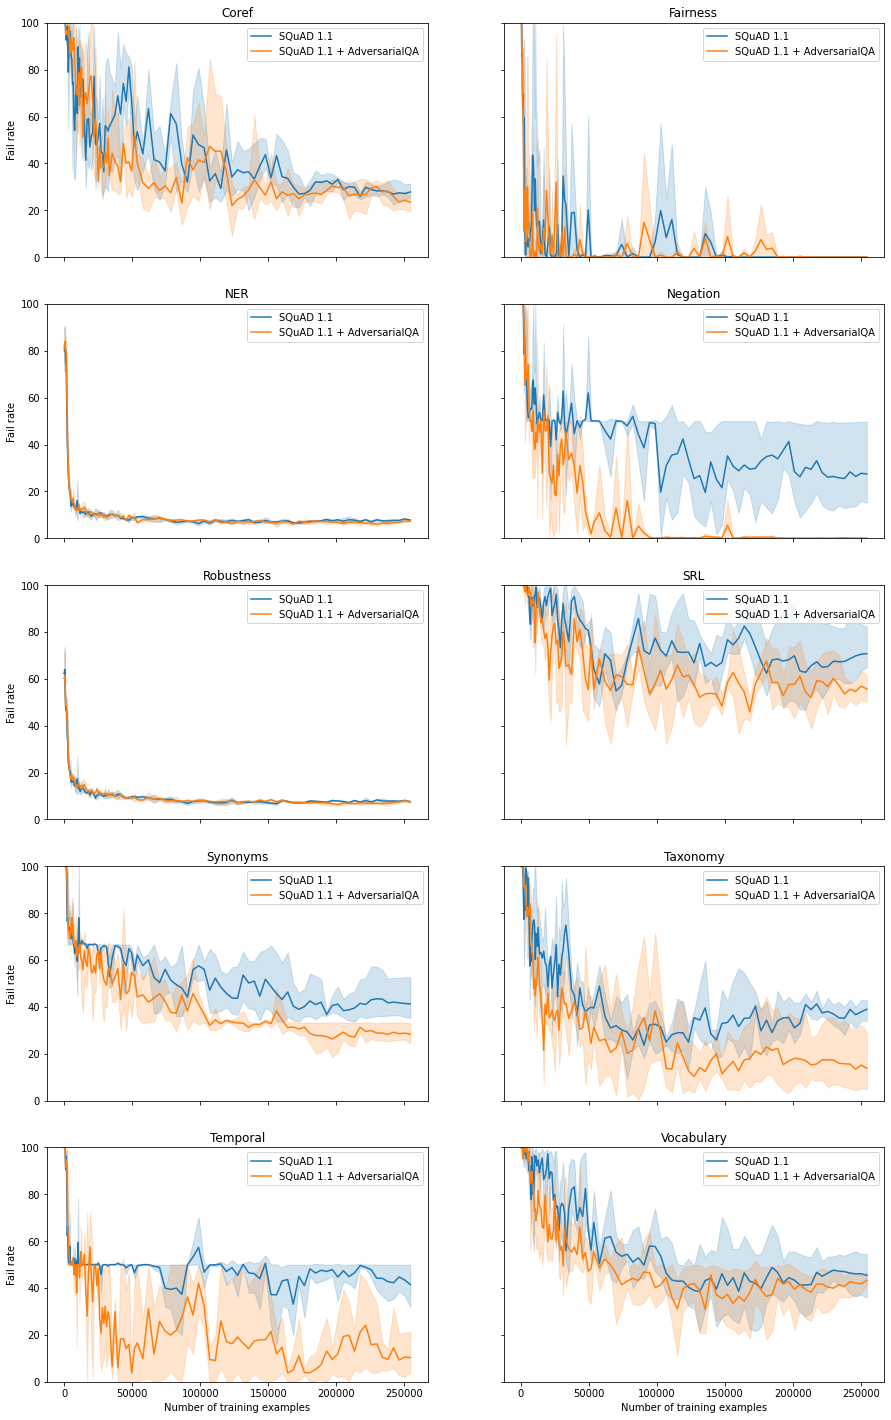

In [17]:
fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(15, 25))

idx_x, idx_y = 0, 0

for i, test_type in enumerate(test_type_df['test_type'].unique()):
    
    plot_df = test_type_df.copy()[test_type_df['test_type'] == test_type]
    
    axs[idx_x, idx_y].set_ylim(0, 100)

    sns.lineplot(x='num_examples', y='fail_rate', hue='model', data=plot_df, ax=axs[idx_x, idx_y], hue_order=['SQuAD 1.1', 'SQuAD 1.1 + AdversarialQA'])
    
    axs[idx_x, idx_y].set_title(f'{test_type}')
    axs[idx_x, idx_y].set_xlabel('Number of training examples')
    axs[idx_x, idx_y].set_ylabel('Fail rate')
    axs[idx_x, idx_y].legend()

    if i % 2 == 0:
        idx_y += 1
    else:
        idx_y -= 1
        idx_x += 1

plt.show()

### Test name

In [18]:
checklist_df.head()

,fail_rate,checkpoint,seed,test_type,test_name,model,num_examples
0,100.0,1,28,Vocabulary,A is COMP than B. Who is more / less COMP?,SQuAD 1.1,32
1,100.0,1,28,Vocabulary,"Intensifiers (very, super, extremely) and redu...",SQuAD 1.1,32
2,100.0,1,28,Taxonomy,"size, shape, age, color",SQuAD 1.1,32
3,100.0,1,28,Taxonomy,Profession vs nationality,SQuAD 1.1,32
4,100.0,1,28,Taxonomy,Animal vs Vehicle,SQuAD 1.1,32


In [19]:
checklist_df['test_name'].unique(), checklist_df['test_name'].nunique()

(array(['A is COMP than B. Who is more / less COMP?',
        'Intensifiers (very, super, extremely) and reducers (somewhat, kinda, etc)?',
        'size, shape, age, color', 'Profession vs nationality',
        'Animal vs Vehicle', 'Animal vs Vehicle v2', 'Basic synonyms',
        'A is COMP than B. Who is antonym(COMP)? B',
        'A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.',
        'Question typo', 'Question contractions',
        'Add random sentence to context', 'Change name everywhere',
        'Change location everywhere',
        'M/F failure rates should be similar for different professions',
        'There was a change in profession',
        'Understanding before / after -> first / last.',
        'Negation in context, may or may not be in question',
        'Negation in question only.', 'Basic coref, he / she',
        'Basic coref, his / her', 'Former / Latter',
        'Agent / object distinction',
     

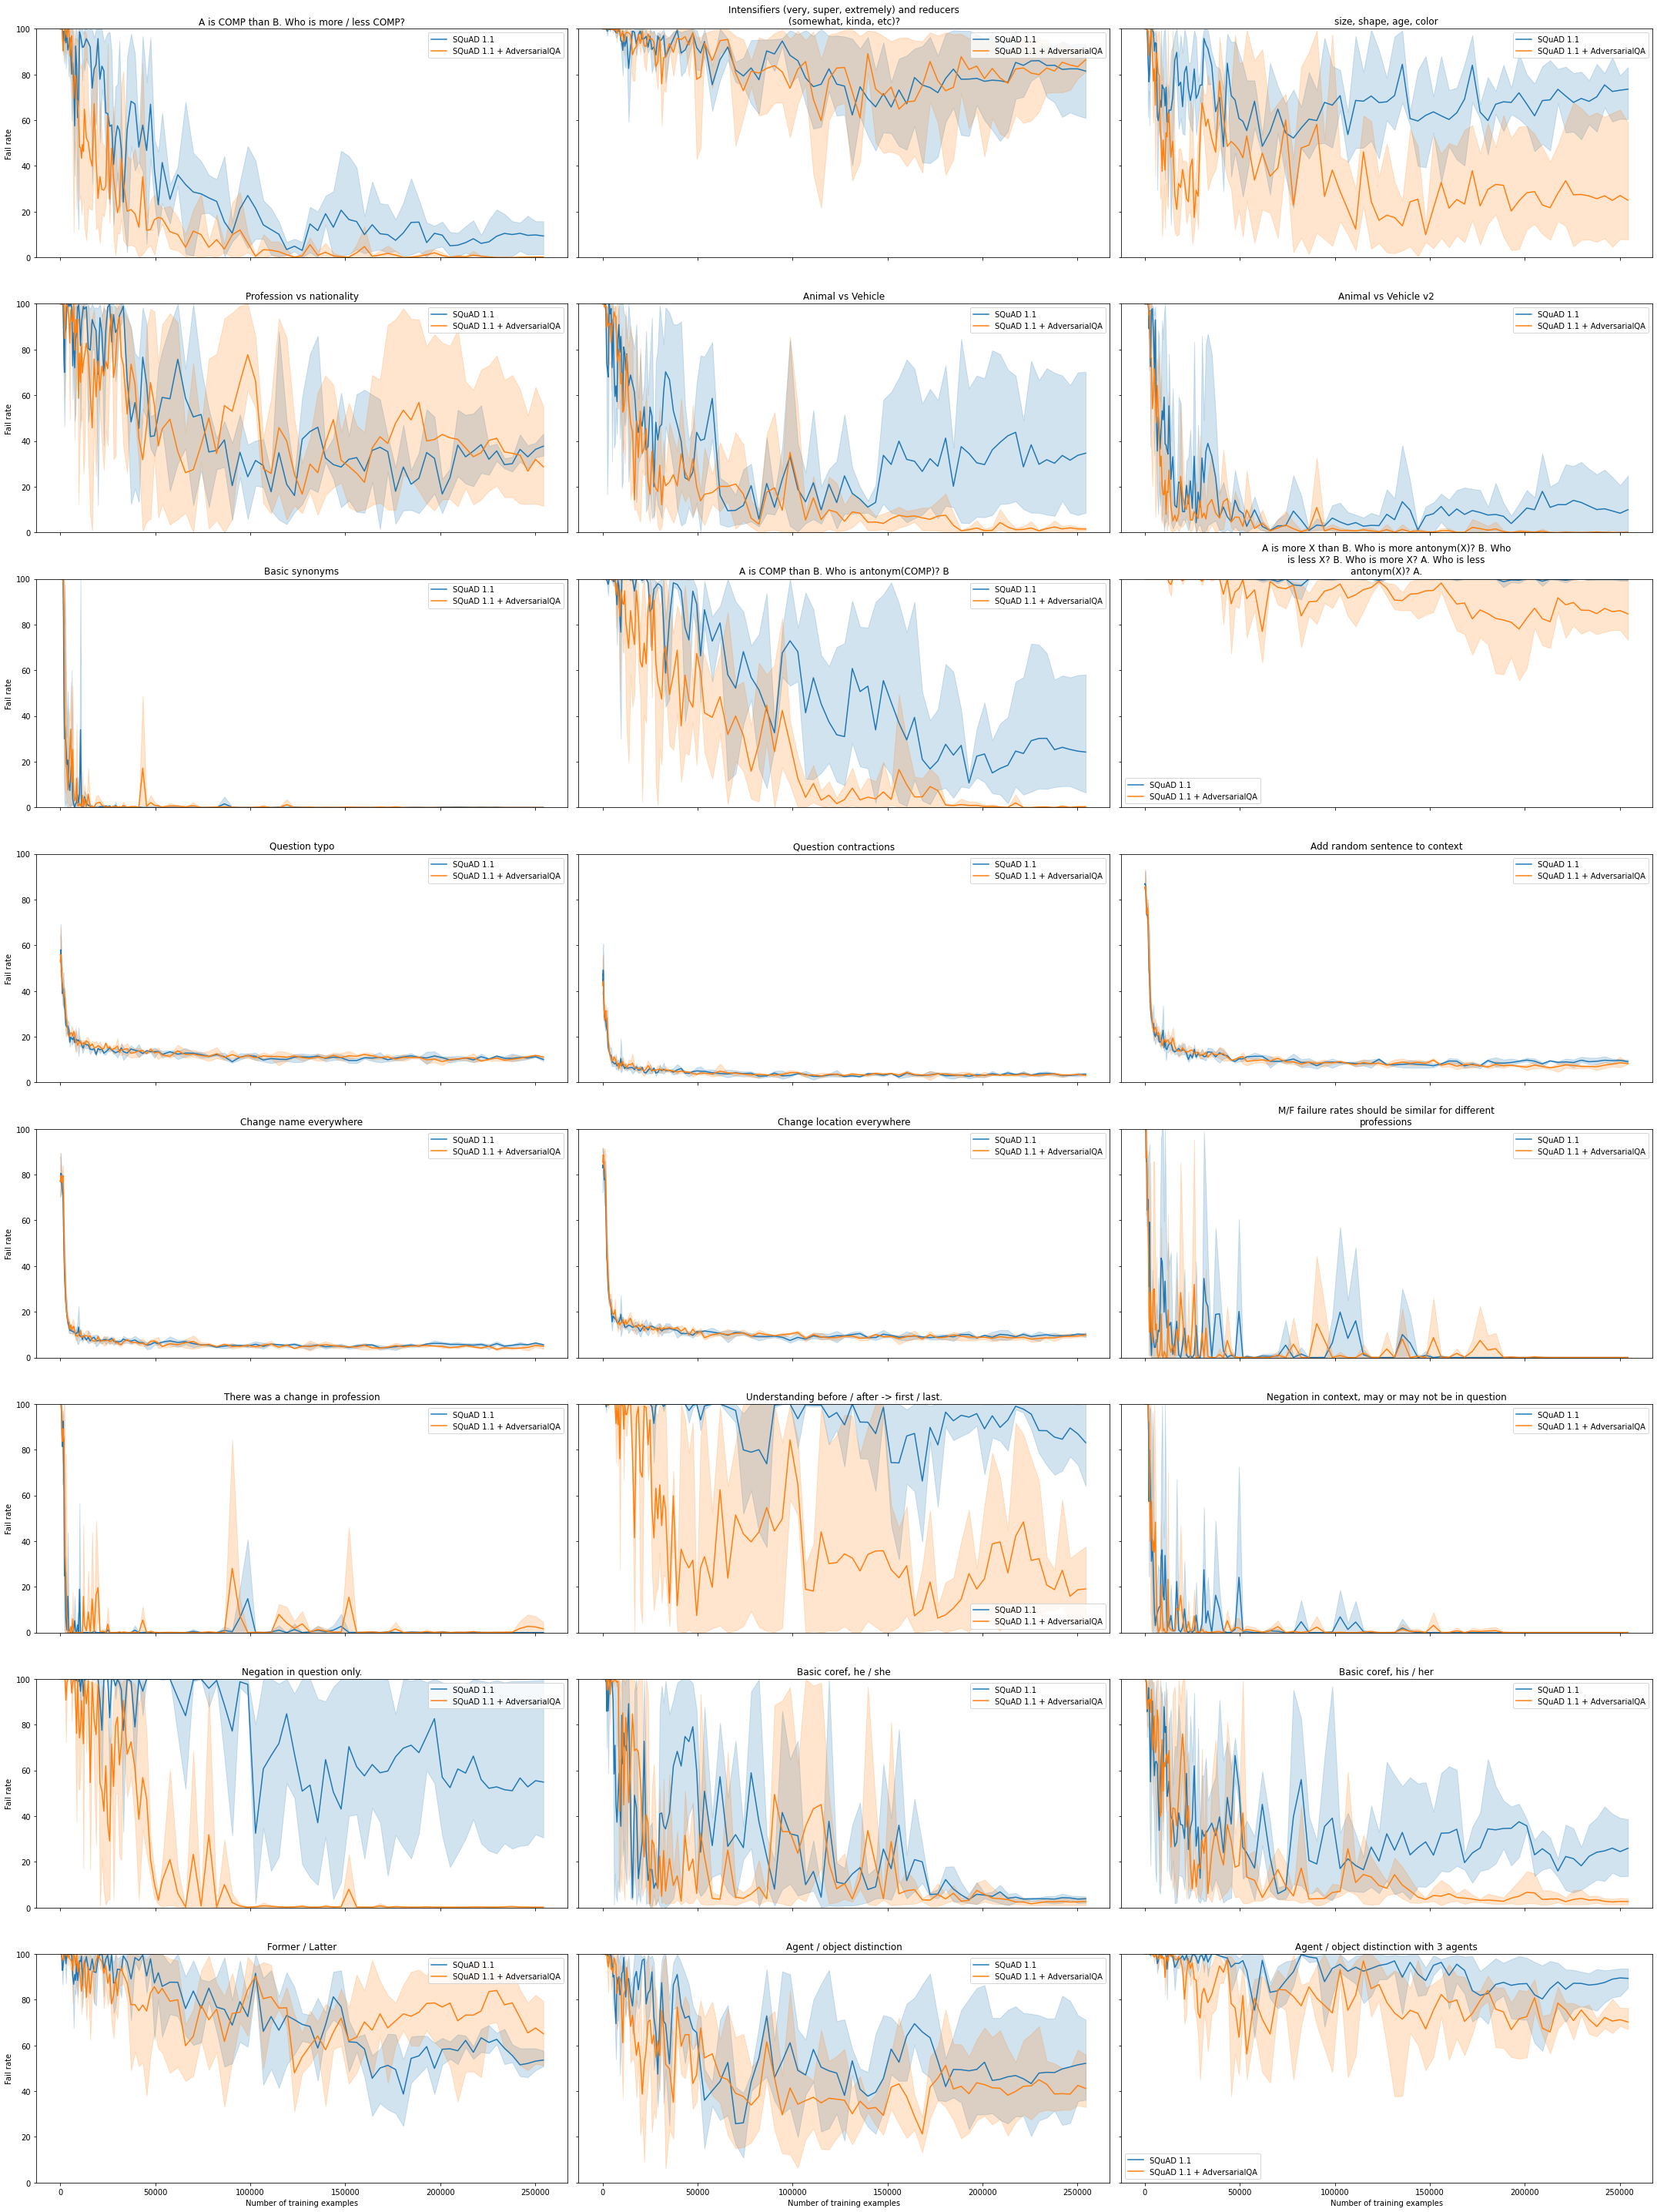

In [22]:
fig, axs = plt.subplots(8, 3, sharex=True, sharey=True, figsize=(30, 40))

idx_x, idx_y = 0, 0

for i, test_name in enumerate(checklist_df['test_name'].unique()):
    
    plot_df = checklist_df.copy()[checklist_df['test_name'] == test_name]
    
    axs[idx_x, idx_y].set_ylim(0, 100)

    sns.lineplot(x='num_examples', y='fail_rate', hue='model', data=plot_df, ax=axs[idx_x, idx_y], hue_order=['SQuAD 1.1', 'SQuAD 1.1 + AdversarialQA'])
    
    axs[idx_x, idx_y].set_title("\n".join(wrap(f"{test_name}", 50)))
    axs[idx_x, idx_y].set_xlabel('Number of training examples')
    axs[idx_x, idx_y].set_ylabel('Fail rate')
    axs[idx_x, idx_y].legend()

    if (i % 3 == 0) | (i % 3 == 1):
        idx_y += 1
    else:
        idx_y -= 2
        idx_x += 1

plt.tight_layout()
plt.savefig('reports/figures/checklist-by-test-name.pdf')
plt.show()